__Name: Brandon Tchaka NIYUNGEKO__

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from my_data_preprocessing_script import info_col, clean_data

import plotly.graph_objs as go
import plotly.offline as pyo
import datetime as dt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, PrecisionRecallDisplay
#!pip3 install imblearn --ignore-installed scikit-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

from sklearn.ensemble import RandomForestClassifier

#!conda install -c conda-forge shap -y
import xgboost as xgb
#!pip install lime

In [3]:
# Loading the preprocessed dataset converted to parquet format
df = pd.read_parquet('data_preprocessed.parquet')

df.head()

,addr_state,annual_inc,application_type,avg_cur_bal,dti,grade,home_ownership,initial_list_status,int_rate,loan_amnt,...,cpi,CPIUS,riskprem,logearnings,logempl_expan,internetuser,internetuserprop,muni_6m,unem_rate,muni_points
0,AK,49800.0,individual,28975,25.120001,C,MORTGAGE,f,0.1531,11875,...,102.619003,237.498,3.2075,6.903546,9.806976,532692.0,0.792596,2.357462,0.065,2.343903
1,AK,34000.0,individual,3776,9.220000,D,OWN,f,0.1849,11500,...,102.619003,237.498,3.2075,6.903546,9.806976,532692.0,0.792596,2.357462,0.065,2.343903
2,AK,34000.0,individual,1656,25.590000,A,RENT,f,0.0890,2300,...,102.619003,237.498,3.2075,6.903546,9.806976,532692.0,0.792596,2.357462,0.065,2.343903
3,AK,50000.0,individual,1563,9.310000,B,RENT,f,0.1409,19600,...,102.619003,235.288,3.2150,6.621259,8.363342,3055233.5,0.769159,2.691933,0.070,2.573472
4,AK,29000.0,individual,2817,8.150000,B,RENT,f,0.1311,3900,...,102.619003,237.231,3.2150,7.212464,8.340933,3044685.0,0.769159,2.691933,0.070,2.559913


In [4]:
type(df)
df.drop(columns=['logempl_expan'], inplace=True)
df.shape

(974317, 36)

In [5]:
info_col(df)

df shape: (974317, 36)


,Data type,Number of unique values,Missing values
addr_state,object,51,0.0
annual_inc,float32,51257,0.0
revol_bal,int32,76025,0.0
revol_util,float64,1262,0.0
sub_grade,object,35,0.0
term_clean,int64,2,0.0
total_acc,int16,144,0.0
verification_status,object,3,0.0
gdppercap,float32,1226,0.0
cpi,float64,456,0.0


In [6]:
df['term_clean'] = df['term_clean'].astype('category')

In [7]:
macro_features = ["CPIUS", "riskprem", "unem_rate", "muni_points", "muni_6m", "internetuserprop", "logearnings", "internetuser", "gdppercap", "cpi"]

In [8]:
categorical_cols = ['addr_state', 'purpose', 'term_clean', 'sub_grade', 'verification_status', 
                    'grade', 'home_ownership', 'initial_list_status', 'application_type']

numerical_cols = [col for col in df.columns if col not in categorical_cols + ['loan_status_target_variable']] 

numerical_base = [col for col in numerical_cols if col not in macro_features]

print(f"Numerical columns: {len(numerical_cols)} - {numerical_cols}")
print(f"Base Numerical columns (without macro features): {len(numerical_base)} - {numerical_base}")
print(f"Macro features: {len(macro_features)} - {macro_features}")
print(f"Categorical columns: {len(categorical_cols)} - {categorical_cols}")
print(f'Total columns: {len(numerical_cols) + len(categorical_cols)}')

print('Dependent variable: "loan_status_target_variable"')


Numerical columns: 26 - ['annual_inc', 'avg_cur_bal', 'dti', 'int_rate', 'loan_amnt', 'loan_date_days_from_reference', 'mort_acc', 'num_accts_ever_120_pd', 'num_sats', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'total_acc', 'gdppercap', 'cpi', 'CPIUS', 'riskprem', 'logearnings', 'internetuser', 'internetuserprop', 'muni_6m', 'unem_rate', 'muni_points']
Base Numerical columns (without macro features): 16 - ['annual_inc', 'avg_cur_bal', 'dti', 'int_rate', 'loan_amnt', 'loan_date_days_from_reference', 'mort_acc', 'num_accts_ever_120_pd', 'num_sats', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'total_acc']
Macro features: 10 - ['CPIUS', 'riskprem', 'unem_rate', 'muni_points', 'muni_6m', 'internetuserprop', 'logearnings', 'internetuser', 'gdppercap', 'cpi']
Categorical columns: 9 - ['addr_state', 'purpose', 'term_clean', 'sub_grade', 'verification_status', 'grade', 'home_owne

In [9]:
def preprocess_data(df, include_macro=True):
    categorical_cols = ['addr_state', 'purpose', 'term_clean', 'sub_grade', 
                        'verification_status', 'grade', 'home_ownership', 
                        'initial_list_status', 'application_type']
    base_numerical_cols = ['annual_inc', 'avg_cur_bal', 'dti', 'int_rate', 
                           'loan_amnt', 'loan_date_days_from_reference', 'mort_acc', 
                           'num_accts_ever_120_pd', 'num_sats', 'num_tl_op_past_12m', 
                           'pct_tl_nvr_dlq', 'pub_rec', 'pub_rec_bankruptcies', 
                           'revol_bal', 'revol_util', 'total_acc']

    # Including macroeconomic features (if specified)
    macro_features = ['CPIUS', 'riskprem', 'unem_rate', 'muni_points', 'muni_6m', 
                      'internetuserprop', 'logearnings', 'internetuser', 'gdppercap', 'cpi'] if include_macro else []
    numerical_cols = base_numerical_cols + macro_features

    # Preprocessing pipelines
    numerical_transformer = Pipeline(steps=[
        ('scaler', RobustScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    X = df.drop('loan_status_target_variable', axis=1)
    y = df['loan_status_target_variable']
    X_processed = preprocessor.fit_transform(X)
    
    return X_processed, y, preprocessor


In [11]:
def evaluate_model(model, X_test, y_test, model_name='Model'):
    """
    Evaluate the model and display evaluation metrics and plots.
    
    Parameters:
        model: The trained machine learning model.
        X_test (DataFrame): Test features.
        y_test (Series): True labels for test data.
        model_name (str): Name of the model for display purposes.
    """
    # ROC-AUC score
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print("ROC-AUC Score:", roc_auc)

    # Precision-Recall curve components
    precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall, precision)
    print("Precision-Recall AUC:", pr_auc)

    # Calculate F1 scores from precision and recall
    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_idx = np.nanargmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 1.0
    print("Optimal threshold by F1:", optimal_threshold)

    # Setup for 2x2 subplot
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[0, 0])
    ax[0, 0].set_title('ROC Curve')

    # Precision-Recall Curve
    pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name=model_name)
    pr_display.plot(ax=ax[0, 1])
    ax[0, 1].set_title('Precision-Recall Curve')
    ax[0, 1].axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    ax[0, 1].legend()

    # Confusion Matrix at Normal Threshold (0.5)
    y_pred_normal = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred_normal)
    ConfusionMatrixDisplay(cm).plot(ax=ax[1, 0])
    ax[1, 0].set_title('Confusion Matrix at Threshold 0.5')

    # Precision and Recall vs. Threshold
    ax[1, 1].plot(thresholds, precision[:-1], 'b--', label='Precision (class=1)')
    ax[1, 1].plot(thresholds, recall[:-1], 'g-', label='Recall (class=1)')
    ax[1, 1].set_ylabel('Precision | Recall')
    ax[1, 1].set_xlabel('Threshold')
    ax[1, 1].set_title('Precision and Recall Scores as function of threshold')
    ax[1, 1].axvline(x=0.5, color='k', linestyle='--', label='Threshold at 0.5')
    ax[1, 1].axhline(y=0.5, color='r', linestyle='--', label='Score at 0.5')
    ax[1, 1].legend(loc='best')

    plt.tight_layout()
    plt.show()
    
    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred_normal))

    return precision, recall, thresholds


# XGBOOST

#### Without macro features

In [44]:
X, y, preprocessor = preprocess_data(df, include_macro=False)
preprocessor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [26]:
# Calculate scale_pos_weight
scale_pos_weight = (0.7854 * 974317) / (0.2146 * 974317)

params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'eval_metric': 'auc',
    'use_label_encoder': False,
    'scale_pos_weight': scale_pos_weight
}

model_xgb = xgb.XGBClassifier(**params)

# Train
model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True, early_stopping_rounds=20)

y_pred_proba = model_xgb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")


/Users/brandontchakaniyungeko/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.70768
[1]	validation_0-auc:0.71071
[2]	validation_0-auc:0.71186
[3]	validation_0-auc:0.71231
[4]	validation_0-auc:0.71295
[5]	validation_0-auc:0.71345
[6]	validation_0-auc:0.71447
[7]	validation_0-auc:0.71486
[8]	validation_0-auc:0.71542
[9]	validation_0-auc:0.71592
[10]	validation_0-auc:0.71664
[11]	validation_0-auc:0.71707
[12]	validation_0-auc:0.71761
[13]	validation_0-auc:0.71827
[14]	validation_0-auc:0.71897
[15]	validation_0-auc:0.71934
[16]	validation_0-auc:0.71973
[17]	validation_0-auc:0.72009
[18]	validation_0-auc:0.72042
[19]	validation_0-auc:0.72094
[20]	validation_0-auc:0.72119
[21]	validation_0-auc:0.72152
[22]	validation_0-auc:0.72189
[23]	validation_0-auc:0.72232
[24]	validation_0-auc:0.72258
[25]	validation_0-auc:0.72293
[26]	validation_0-auc:0.72355
[27]	validation_0-auc:0.72382
[28]	validation_0-auc:0.72416
[29]	validation_0-auc:0.72464
[30]	validation_0-auc:0.72491
[31]	validation_0-auc:0.72515
[32]	validation_0-auc:0.72542
[33]	validation_0-au

ROC-AUC Score: 0.7330612014406136
Precision-Recall AUC: 0.4265223599096758
Optimal threshold by F1: 0.5278868


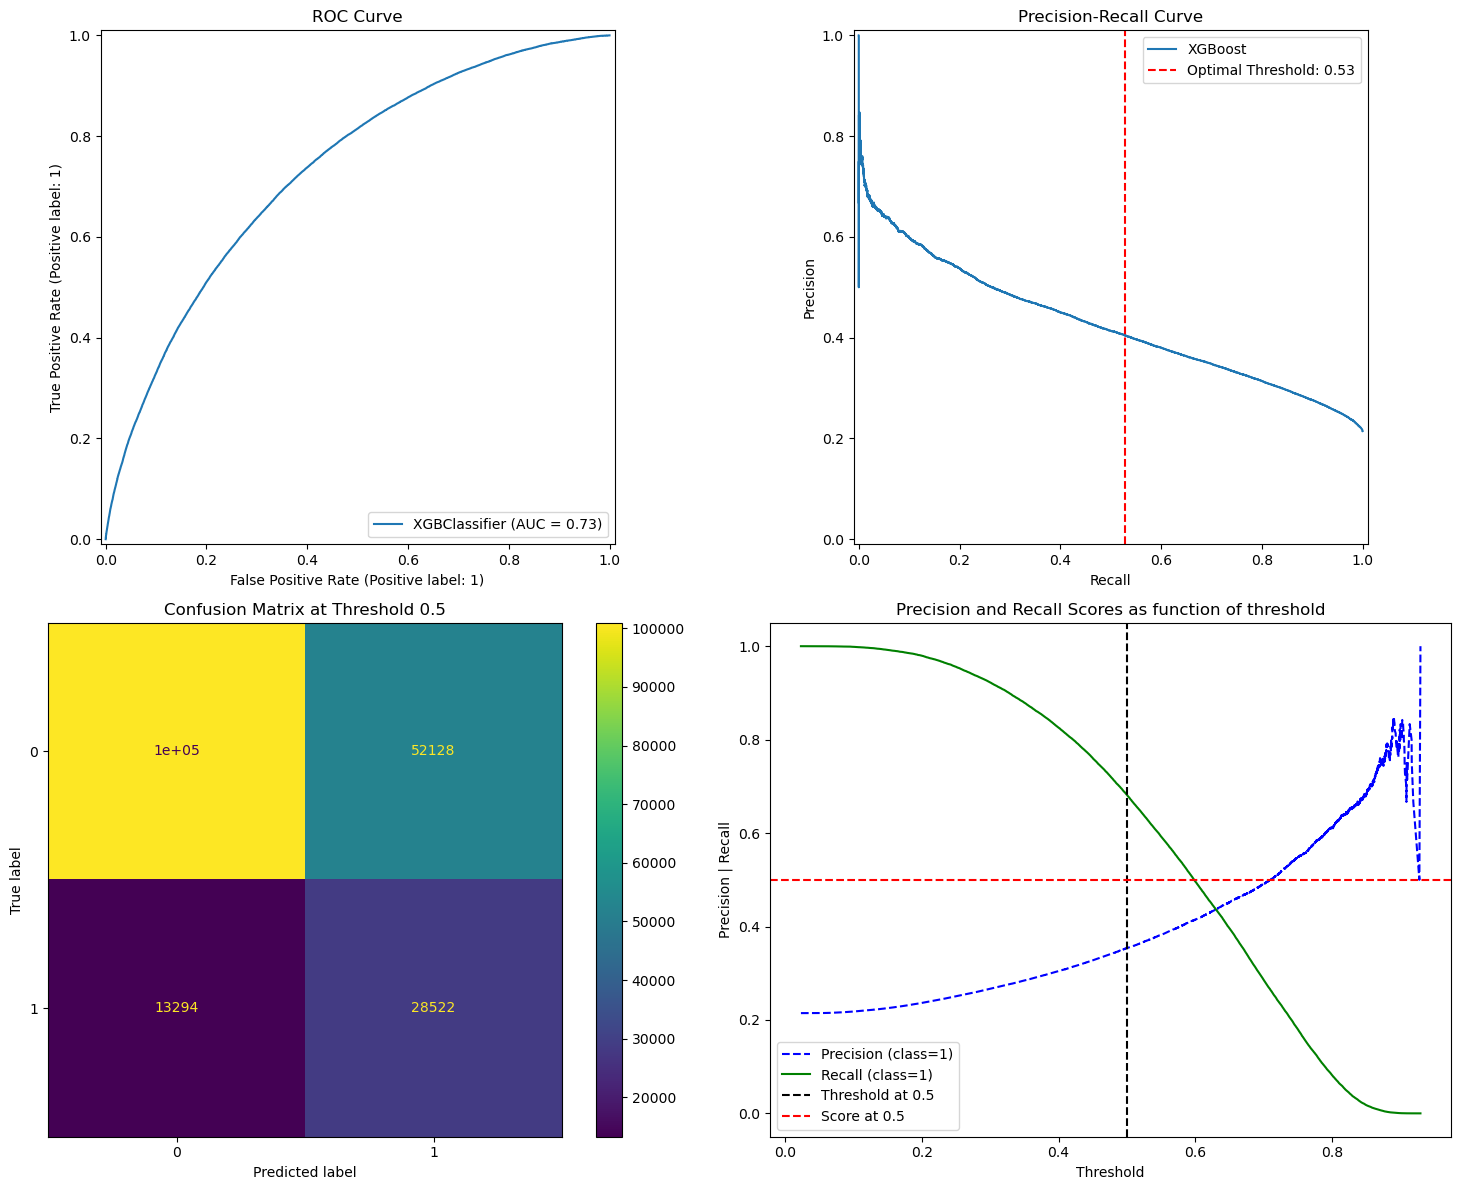


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.66      0.76    153048
           1       0.35      0.68      0.47     41816

    accuracy                           0.66    194864
   macro avg       0.62      0.67      0.61    194864
weighted avg       0.77      0.66      0.69    194864



In [27]:
precision_model_xgboost_base, recall_model_xgboost_base, thresholds_xgboost_base = evaluate_model(model_xgb, X_test, y_test, model_name='XGBoost')

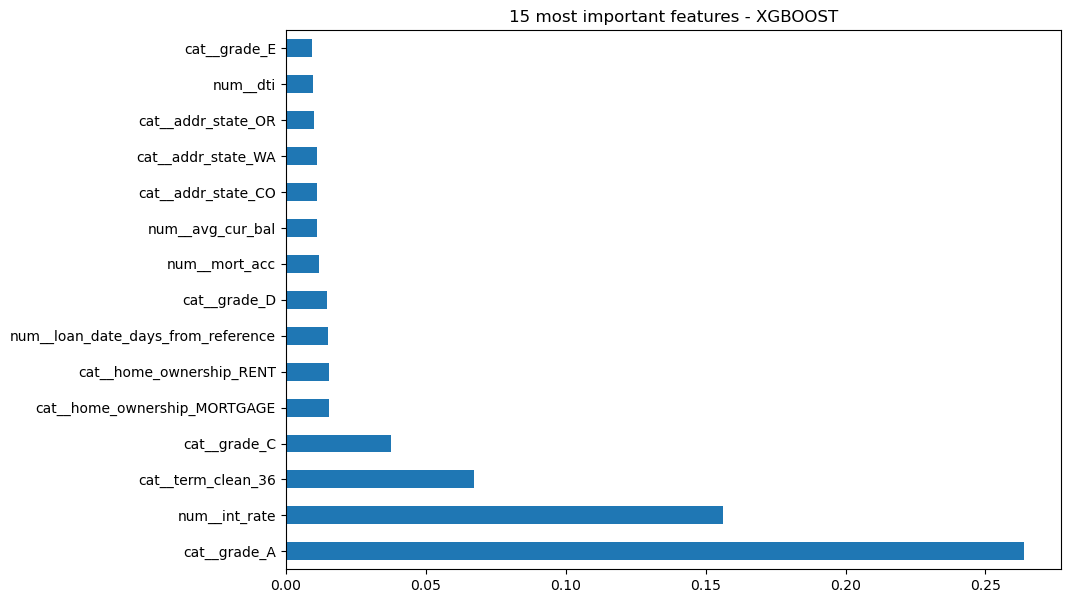

In [28]:
feature_names = preprocessor.get_feature_names_out()
features_importances_base = pd.Series(model_xgb.feature_importances_, index=feature_names)
features_importances_base.nlargest(15).plot(kind='barh', figsize=(10,7))
plt.title("15 most important features - XGBOOST")
plt.show()


#### Hyperparameter tuning

In [38]:
%%time
scale_pos_weight = (0.7854 * 974317) / (0.2146 * 974317)

params = {'learning_rate': [0.01, 0.05, 0.1,0.2],
         'n_estimators': [100, 200, 400],
         'scale_pos_weight': [scale_pos_weight, 2, 3],
         'max_depth': [3,4, 7,9,10, 12],
         'gamma': [0, 0.01, 0.1],
         'min_child_weight': [1,3,9,10]
         }

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# RandomizedSearchCV to tune the hyperparameter
random_base_1 = RandomizedSearchCV(model_xgb, 
                            param_distributions=params, 
                            cv=kfold,
                            n_iter=10, 
                            scoring='recall',
                            n_jobs=-1)

random_base_1.fit(X_train, y_train)

print('Best hyperparameter:', random.best_params_)
print('Best score:', random.best_score_)

/Users/brandontchakaniyungeko/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best hyperparameter: {'scale_pos_weight': 3.659832246039142, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1}
Best score: 0.7519490177159288
CPU times: user 2min 21s, sys: 29 s, total: 2min 50s
Wall time: 1min 50s


ROC-AUC Score: 0.7817012817750066
Precision-Recall AUC: 0.47647909998251037
Optimal threshold by F1: 0.54825073


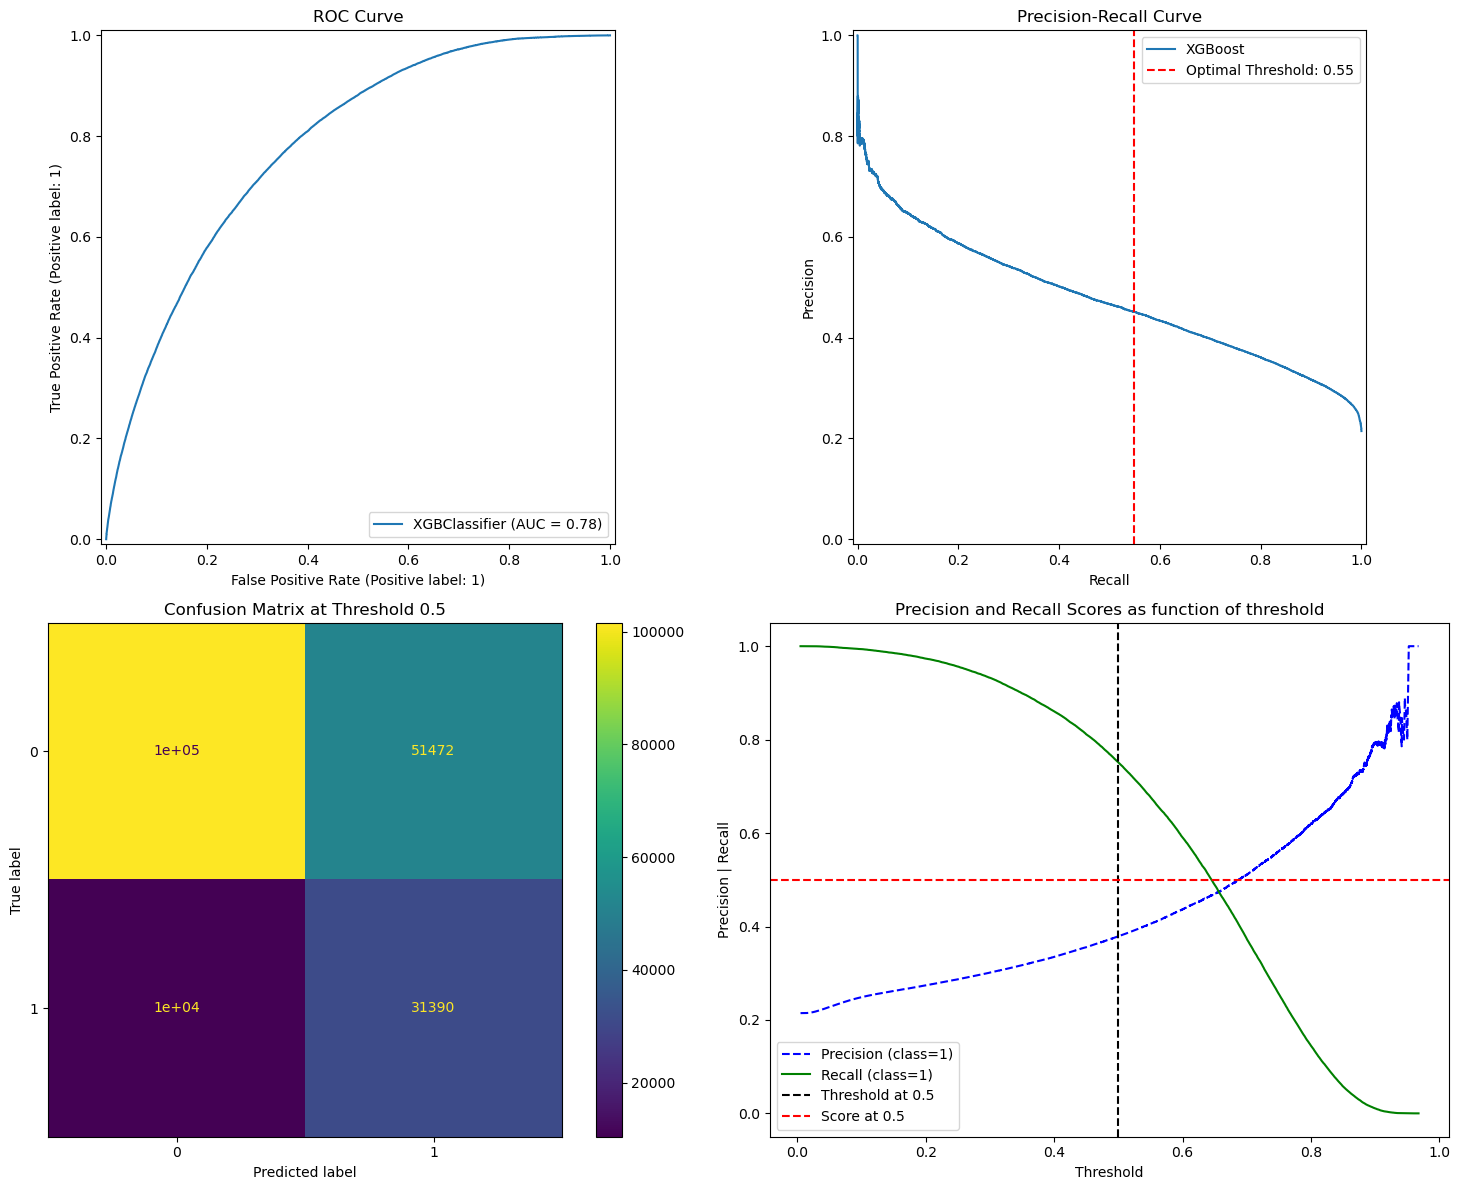


Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.66      0.77    153048
           1       0.38      0.75      0.50     41816

    accuracy                           0.68    194864
   macro avg       0.64      0.71      0.64    194864
weighted avg       0.79      0.68      0.71    194864



In [48]:
best_model_base = random_base_1.best_estimator_
evaluate_model(best_model_base, X_test, y_test, model_name='XGBoost');

In [39]:
%%time
scale_pos_weight = (0.7854 * 974317) / (0.2146 * 974317)

params = {'learning_rate': [0.01, 0.05, 0.1,0.2],
         'n_estimators': [100, 200, 400],
         'scale_pos_weight': [scale_pos_weight, 2],
         'max_depth': [3,4, 7,9,10, 12, 15, 20],
         'gamma': [0, 0.01, 0.1],
         'min_child_weight': [1,3,9,10]
         }

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# RandomizedSearchCV to tune the hyperparameter
random_base_1 = RandomizedSearchCV(model_xgb, 
                            param_distributions=params, 
                            cv=kfold,
                            n_iter=10, 
                            scoring='roc_auc',
                            n_jobs=-1)

random_base_1.fit(X_train, y_train)

print('Best hyperparameter:', random.best_params_)
print('Best score:', random.best_score_)

Best hyperparameter: {'scale_pos_weight': 3.659832246039142, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1}
Best score: 0.7519490177159288
CPU times: user 34.2 s, sys: 15.6 s, total: 49.8 s
Wall time: 2min 13s


#### With Macro features

In [46]:
X, y, preprocessor = preprocess_data(df, include_macro=True)
preprocessor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
# Calculate scale_pos_weight
scale_pos_weight = (0.7854 * 974317) / (0.2146 * 974317)

params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'eval_metric': 'auc',
    'use_label_encoder': False,
    'scale_pos_weight': scale_pos_weight
}

model_xgb_macro = xgb.XGBClassifier(**params)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train
model_xgb_macro.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True, early_stopping_rounds=30)

# Evaluate
y_pred_proba_macro = model_xgb_macro.predict_proba(X_test)[:, 1]
roc_auc_macro = roc_auc_score(y_test, y_pred_proba_macro)
print(f"ROC AUC Score: {roc_auc_macro}")


/Users/brandontchakaniyungeko/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.73638
[1]	validation_0-auc:0.74082
[2]	validation_0-auc:0.74245
[3]	validation_0-auc:0.74381
[4]	validation_0-auc:0.74540
[5]	validation_0-auc:0.74640
[6]	validation_0-auc:0.74739
[7]	validation_0-auc:0.74854
[8]	validation_0-auc:0.74894
[9]	validation_0-auc:0.74957
[10]	validation_0-auc:0.75023
[11]	validation_0-auc:0.75107
[12]	validation_0-auc:0.75185
[13]	validation_0-auc:0.75240
[14]	validation_0-auc:0.75297
[15]	validation_0-auc:0.75359
[16]	validation_0-auc:0.75431
[17]	validation_0-auc:0.75483
[18]	validation_0-auc:0.75539
[19]	validation_0-auc:0.75582
[20]	validation_0-auc:0.75631
[21]	validation_0-auc:0.75687
[22]	validation_0-auc:0.75740
[23]	validation_0-auc:0.75816
[24]	validation_0-auc:0.75860
[25]	validation_0-auc:0.75917
[26]	validation_0-auc:0.75962
[27]	validation_0-auc:0.76016
[28]	validation_0-auc:0.76051
[29]	validation_0-auc:0.76099
[30]	validation_0-auc:0.76139
[31]	validation_0-auc:0.76190
[32]	validation_0-auc:0.76231
[33]	validation_0-au

ROC-AUC Score: 0.774818717897586
Precision-Recall AUC: 0.4655425869471699
Optimal threshold by F1: 0.55089563


/var/folders/9q/y31m_zrs5m3cz8zzkbtrtplm0000gn/T/ipykernel_11026/1162154942.py:21: RuntimeWarning:

invalid value encountered in divide



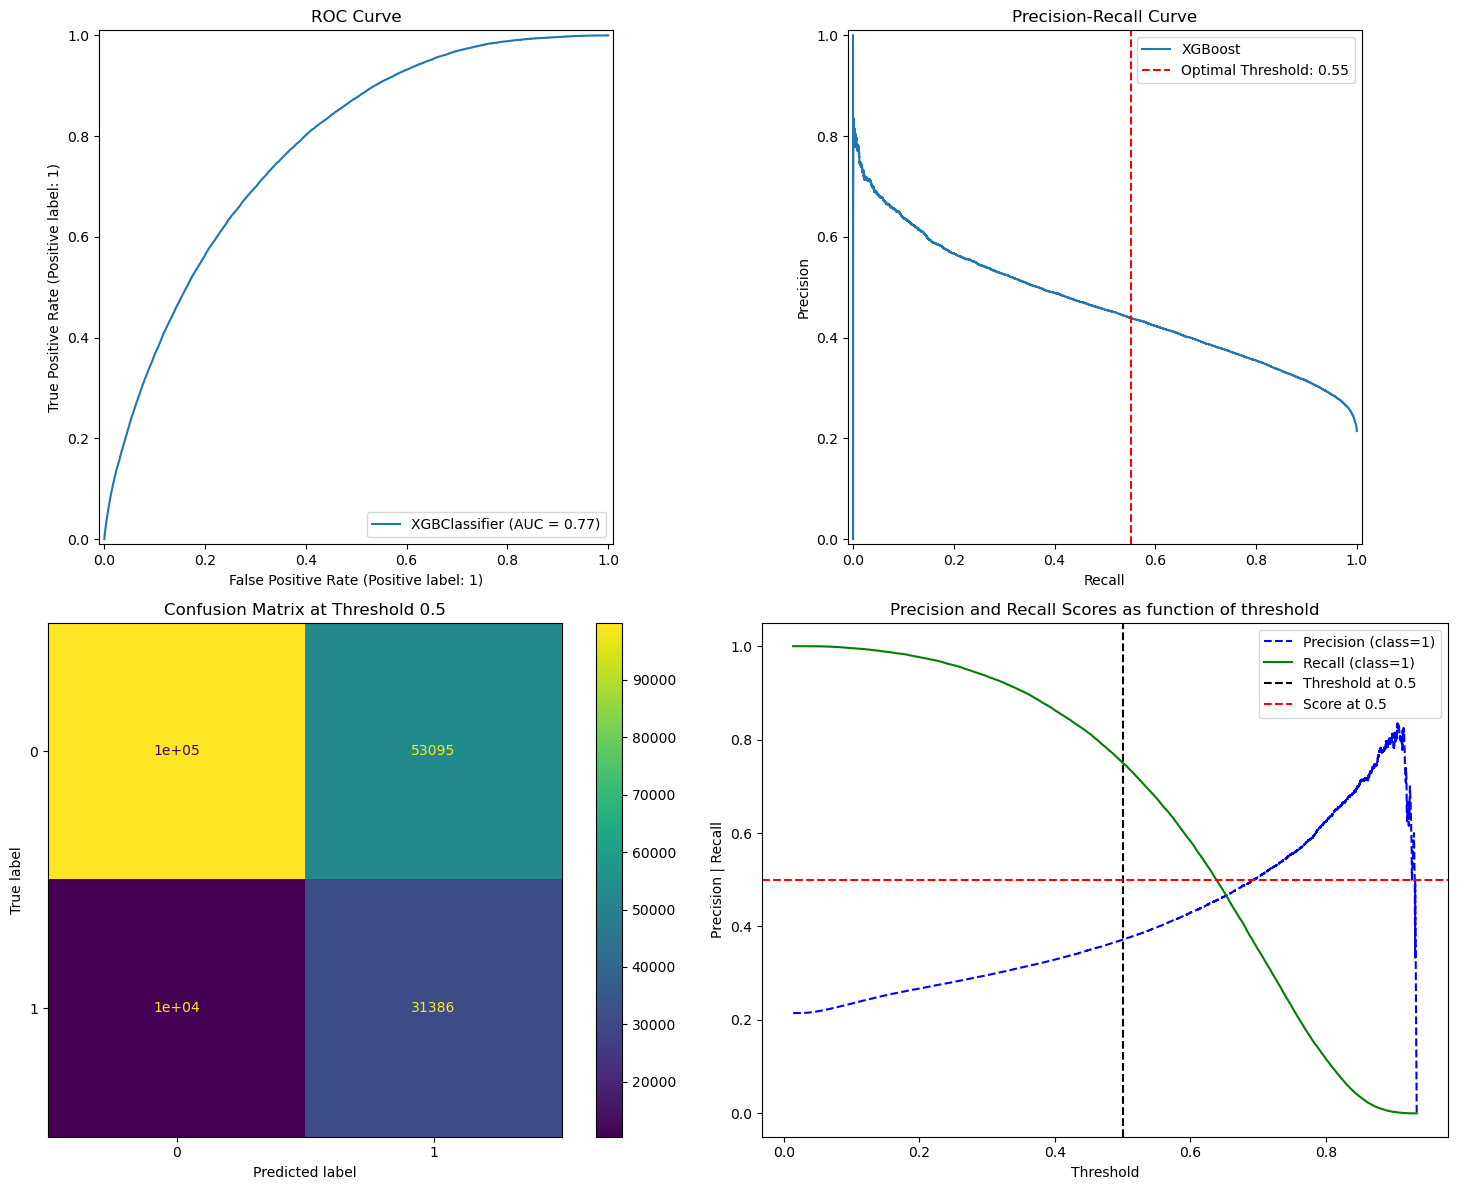


Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.65      0.76    153048
           1       0.37      0.75      0.50     41816

    accuracy                           0.67    194864
   macro avg       0.64      0.70      0.63    194864
weighted avg       0.79      0.67      0.70    194864



In [33]:
precision_model_xgboost_macro, recall_model_xgboost_macro, thresholds_xgboost_macro = evaluate_model(model_xgb_macro, X_test, y_test, model_name='XGBoost')

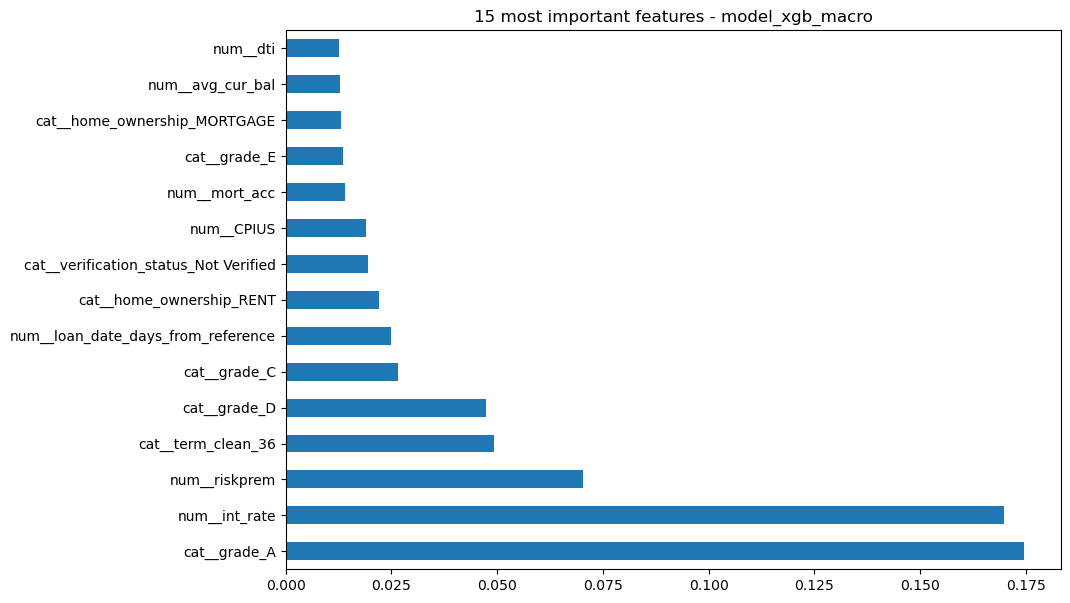

In [34]:
feature_names = preprocessor.get_feature_names_out()
features_importances_xgb_macro = pd.Series(model_xgb_macro.feature_importances_, index=feature_names)
features_importances_xgb_macro.nlargest(15).plot(kind='barh', figsize=(10,7))
plt.title("15 most important features - model_xgb_macro")
plt.show()

#### Hyperparameter Tuning

In [35]:
%%time
scale_pos_weight = (0.7854 * 974317) / (0.2146 * 974317)

params = {'learning_rate': [0.01, 0.05, 0.1,0.2],
         'n_estimators': [100, 200, 400],
         'scale_pos_weight': [scale_pos_weight, 2, 3],
         'max_depth': [3,4, 7,9,10, 12],
         'gamma': [0, 0.01, 0.1],
         'min_child_weight': [1,3,9,10]
         }

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# RandomizedSearchCV to tune the hyperparameter
random = RandomizedSearchCV(model_xgb_macro, 
                            param_distributions=params, 
                            cv=kfold, 
                            n_iter=10, 
                            scoring='recall',
                            n_jobs=-1)

random.fit(X_train, y_train)

print('Best hyperparameter:', random.best_params_)
print('Best score:', random.best_score_)

/Users/brandontchakaniyungeko/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best hyperparameter: {'scale_pos_weight': 3.659832246039142, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1}
Best score: 0.7519490177159288
CPU times: user 1min 47s, sys: 17.5 s, total: 2min 5s
Wall time: 1min 49s


In [36]:
%%time
scale_pos_weight = (0.7854 * 974317) / (0.2146 * 974317)

params = {'learning_rate': [0.01, 0.05, 0.1,0.2],
         'n_estimators': [100, 200, 400],
         'scale_pos_weight': [scale_pos_weight, 2, 3],
         'max_depth': [3,4, 7,9,10, 12],
         'gamma': [0, 0.01, 0.1],
         'min_child_weight': [1,3,9,10]
         }

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# RandomizedSearchCV to tune the hyperparameter
random_1 = RandomizedSearchCV(model_xgb_macro, 
                            param_distributions=params, 
                            cv=kfold, 
                            n_iter=5, 
                            scoring='roc_auc',
                            n_jobs=-1)

random_1.fit(X_train, y_train)

print('Best hyperparameter:', random_1.best_params_)
print('Best score:', random_1.best_score_)

Best hyperparameter: {'scale_pos_weight': 3.659832246039142, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.1}
Best score: 0.7775853174592354
CPU times: user 45.6 s, sys: 11 s, total: 56.6 s
Wall time: 1min 7s
